In [24]:
#Text classifier using Embedding Layer

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [26]:
#To unzip and read the csv file inside the zip file

import zipfile

with zipfile.ZipFile('./BBC News Train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_data')

In [27]:
with open("extracted_data/BBC News Train.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

ArticleId,Text,Category

The second line (first data point) looks like this:

1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in e

## Defining useful global variables

VOCAB_SIZE: The maximum number of words to keep, based on word frequency. Defaults to 1000.

EMBEDDING_DIM: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.

MAX_LENGTH: Maximum length of all sequences. Defaults to 120.

TRAINING_SPLIT: Proportion of data used for training. Defaults to 0.8

In [28]:
# Define the global variables
VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRAINING_SPLIT = 0.8

## Loading and pre-processing the data

In [29]:
data_dir = "./extracted_data/BBC News Train.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=1, dtype='str', comments=None)
print(f"Shape of the data: {data.shape}")
print(f"{data[0]}\n{data[1]}")

Shape of the data: (1490, 3)
['1833'
 'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures 

In [30]:
# Test the function
print(f"There are {len(data)} sentence-label pairs in the dataset.\n")
print(f"First sentence has {len((data[0,1]).split())} words.\n")
print(f"The first 5 labels are {data[:5,2]}")

There are 1490 sentence-label pairs in the dataset.

First sentence has 301 words.

The first 5 labels are ['business' 'business' 'business' 'tech' 'business']


## Training - Validation Datasets

Now you will code the `train_val_datasets` function, which, given the `data` DataFrame, should return the training and validation datasets, consisting of `(text, label)` pairs. For this last part, you will be using the [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) method.

In [31]:
# train_val_datasets
def train_val_datasets(data):
    '''
    Splits data into traning and validations sets
    
    Args:
        data (np.array): array with two columns, first one is the label, the second is the text
    
    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    '''
    ### START CODE HERE ###

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(0.8 * len(data))

    # Slice the dataset to get only the texts. Remember that texts are on the second column
    texts = data[:,1]
    # Slice the dataset to get only the labels. Remember that labels are on the first column
    labels = data[:,2]
    # Split the sentences and labels into train/validation splits. Write your own code below
    train_texts = texts[:train_size]
    validation_texts = texts[train_size:]
    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]
    
    # Create the train and validation datasets from the splits
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))
    
	### END CODE HERE ### 
    
    return train_dataset, validation_dataset

In [32]:
# Create the datasets
train_dataset, validation_dataset = train_val_datasets(data)
print('Name: Sam Israel D       Register Number: 212222230128      ')
print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

Name: Sam Israel D       Register Number: 212222230128      
There are 1192 sentence-label pairs for training.

There are 298 sentence-label pairs for validation.



## Vectorization - Sequences and padding

In [33]:
def standardize_func(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (tf.string): sentence to remove the stopwords from

    Returns:
        sentence (tf.string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]

    # Sentence converted to lowercase-only
    sentence = tf.strings.lower(sentence)

    # Remove stopwords
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")

    # Remove punctuation
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")


    return sentence

## 2. fit_vectorizer
Next complete the fit_vectorizer function below. This function should return a TextVectorization layer that has already been fitted on the training sentences. The vocabulary learned by the vectorizer should have VOCAB_SIZE size, and truncate the output sequences to have MAX_LENGTH length.

Remember to use the custom function standardize_func to standardize each sentence in the vectorizer. You can do this by passing the function to the standardize parameter of TextVectorization.

In [34]:
# fit_vectorizer
def fit_vectorizer(train_sentences, standardize_func):
    '''
    Defines and adapts the text vectorizer

    Args:
        train_sentences (tf.data.Dataset): sentences from the train dataset to fit the TextVectorization layer
        standardize_func (FunctionType): function to remove stopwords and punctuation, and lowercase texts.
    Returns:
        TextVectorization: adapted instance of TextVectorization layer
    '''
    ### START CODE HERE ###

    # If train_sentences is a NumPy array, convert it to a TensorFlow Dataset


    # Initialize the TextVectorization layer
    vectorizer = tf.keras.layers.TextVectorization( 
		standardize=standardize_func,
		max_tokens=VOCAB_SIZE,
		output_sequence_length=MAX_LENGTH
	) 
    
    # Adapt the vectorizer to the training sentences
    vectorizer.adapt(train_sentences)

    ### END CODE HERE ###

    return vectorizer

In [35]:
# Create the vectorizer
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()
print('Name: Sam Israel D       Register Number: 212222230128       ')
print(f"Vocabulary contains {vocab_size} words\n")

Name: Sam Israel D       Register Number: 212222230128       
Vocabulary contains 1000 words



2024-11-13 22:30:34.398012: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 3. fit_label_encoder

Remember your categories are also text labels, so you need to encode the labels as well. For this complete the `tokenize_labels` function below.

- Use the function [`tf.keras.layers.StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) to encode the labels. Use the correct parameters so that you don't include any OOV tokens.
- You should fit the tokenizer to all the labels to avoid the case of a particular label not being present in the validation set. Since you are dealing with labels there should never be an OOV label. For this, you can concatenate the two datasets using the [`concatenate`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#concatenate) method from `tf.data.Dataset` objects.

In [36]:
# fit_label_encoder
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    ### START CODE HERE ###
    
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.
    
    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(oov_token=None, mask_token=None, num_oov_indices=0)
    
    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)
   
    ### END CODE HERE ###
    
    return label_encoder

In [37]:
# Create the label encoder
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
print('Name: Sam Israel D       Register Number: 212222230128       ')
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Name: Sam Israel D       Register Number: 212222230128       
Unique labels: ['sport', 'business', 'politics', 'entertainment', 'tech']


### 4. preprocess_dataset

Now that you have trained the vectorizer for the texts and the encoder for the labels, it's time for you to actually transform the dataset. For this complete the `preprocess_dataset` function below.
Use this function to set the dataset batch size to 32

- You can apply the preprocessing to each pair or text and label by using the [`.map`]method.
- You can set the batchsize to any Dataset by using the [`.batch`] method.

In [38]:
# GRADED FUNCTION: preprocess_dataset
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    """Apply the preprocessing to a dataset

    Args:
        dataset (tf.data.Dataset): dataset to preprocess
        text_vectorizer (tf.keras.layers.TextVectorization ): text vectorizer
        label_encoder (tf.keras.layers.StringLookup): label encoder

    Returns:
        tf.data.Dataset: transformed dataset
    """
    
    ### START CODE HERE ###

    # Convert the Dataset sentences to sequences, and encode the text labels
    dataset = dataset.map(lambda text, label: (text_vectorizer(text), label_encoder(label)))
    dataset = dataset.batch(32) # Set a batchsize of 32
    
	### END CODE HERE ###
    
    return dataset

In [39]:
# Preprocess your dataset
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

In [40]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())
print('Name: Sam Israel D       Register Number: 212222230128     ')
print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Name: Sam Israel D       Register Number: 212222230128     
Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


## 5: create_model
Define the model that will classify each text as being part of a certain category.

The last layer should be a Dense layer with 5 units (since there are 5 categories) with a softmax activation.
You should also compile your model using an appropriate loss function and optimizer.
You can use any architecture you want but keep in mind that this problem doesn't need many layers to be solved successfully. You don't need any layers beside Embedding, GlobalAveragePooling1D and Dense layers but feel free to try out different architectures.

In [41]:
def create_model():
    """
    Creates a text classifier model.
    Returns:
      tf.keras Model: the text classifier model.
    """
    
    ### START CODE HERE ###

    # Define the model architecture
    model = tf.keras.Sequential([ 
        tf.keras.Input(shape=(MAX_LENGTH,)),  
        tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),  
        tf.keras.layers.GlobalAveragePooling1D(),  
        tf.keras.layers.Dense(24, activation='relu'), 
        tf.keras.layers.Dense(5, activation='softmax') 
    ])
    
    # Compile the model with the categorical cross-entropy loss, Adam optimizer, and accuracy as the metric
    model.compile(
        loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
        optimizer='adam',  # Optimizer
        metrics=['accuracy']  # We want to track accuracy during training
    ) 

    ### END CODE HERE ###

    return model

In [42]:
# Get the untrained model
model = create_model()

In [43]:
example_batch = train_proc_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


In [44]:
history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.2490 - loss: 1.6028 - val_accuracy: 0.4161 - val_loss: 1.5878
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3978 - loss: 1.5655 - val_accuracy: 0.4430 - val_loss: 1.5437
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.4769 - loss: 1.5074 - val_accuracy: 0.6074 - val_loss: 1.4546
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.6584 - loss: 1.4008 - val_accuracy: 0.7550 - val_loss: 1.3088
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7893 - loss: 1.2346 - val_accuracy: 0.8154 - val_loss: 1.1212
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8281 - loss: 1.0315 - val_accuracy: 0.8557 - val_loss: 0.9346
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8539 - loss: 0.8358 - val_accuracy: 0.8591 - val_loss: 0.7752
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8963 - loss: 0.6742 - val_accuracy: 0.8993 - v

Name: Sam Israel D       Register Number: 212222230128       


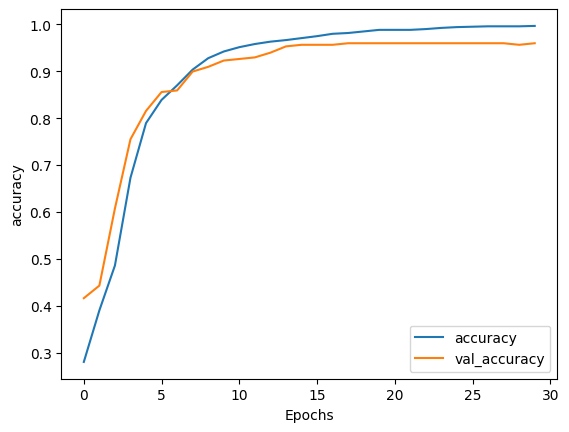

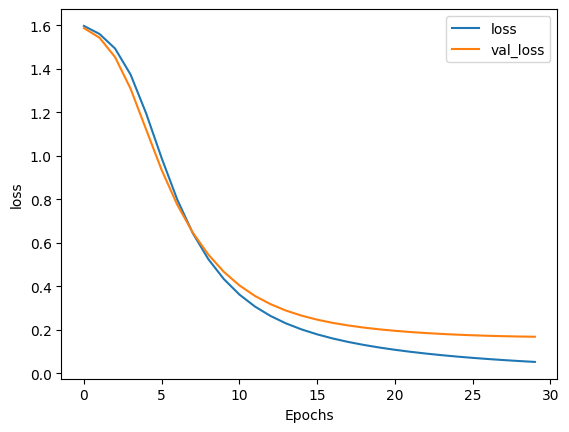

In [45]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
print('Name: Sam Israel D       Register Number: 212222230128       ')
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")